In [ ]:
import torch, os, math, gzip, pickle
import matplotlib.pyplot as plt
from urllib.request import urlretrieve
from pathlib import Path

import torchvision as tv
import torchvision.transforms.functional as tvf
from torchvision import io
from torch.utils.cpp_extension import load_inline

In [ ]:
path_img = Path('puppy.jpg')
if not path_img.is_file():
    urlretrieve('https://upload.wikimedia.org/wikipedia/commons/thumb/4/43/Cute_dog.jpg/1600px-Cute_dog.jpg', 'puppy.jpg')

In [ ]:
img = io.read_image('puppy.jpg')
print(img.shape)
img[:2, :3, :4]

torch.Size([3, 1066, 1600])


tensor([[[117, 119, 117, 113],
         [119, 129, 129, 113],
         [130, 126, 122, 115]],

        [[ 83,  85,  85,  80],
         [ 85,  97,  97,  82],
         [ 98,  93,  89,  83]]], dtype=torch.uint8)

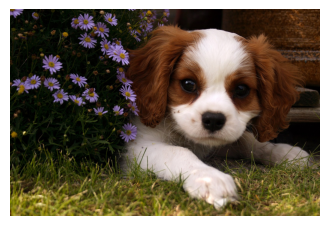

In [ ]:
def show_img(x, figsize=(4, 3), **kwargs):
    plt.figure(figsize=figsize)
    plt.axis('off')
    if len(x.shape) == 3:
      x = x.permute(1, 2, 0)
    plt.imshow(x.cpu(), **kwargs)
show_img(img)

In [ ]:
img2 = tvf.resize(img, 150, antialias=True)
ch, h, w = img2.shape
ch, h, w, h*w

(3, 150, 225, 33750)

In [ ]:
def rgb2grey_py(x):
  c, h, w, = x.shape
  n = h*w
  x = x.flatten()
  res = torch.empty(n, dtype=x.dtype, device=x.device)
  for i in range(n):
    res[i] = (0.2989*x[i] + 0.5870*x[i+n] + 0.1140*x[i+2*n])
  return res.view(h, w)

In [ ]:
%%time

img_g = rgb2grey_py(img2)

CPU times: user 1.34 s, sys: 4.4 ms, total: 1.34 s
Wall time: 1.34 s


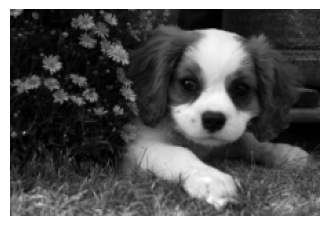

In [ ]:
show_img(img_g, cmap='gray')

In [ ]:
def run_kernel(f, times, *args):
  for i in range(times):
    f(i, *args)

def rgb2grey_k(i, x, out, n):
    out[i] = 0.2989*x[i] + 0.5870*x[i+n] + 0.1140*x[i+2*n]

def rgb2grey_pyk(x):
  c, h, w, = x.shape
  n = h*w
  x = x.flatten()
  res = torch.empty(n, dtype=x.dtype, device=x.device)
  run_kernel(rgb2grey_k, n, x, res, n)

  return res.view(h, w)

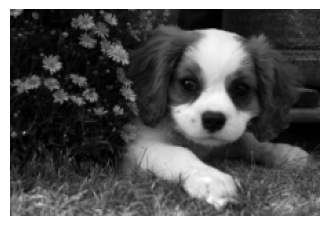

In [ ]:
img_g = rgb2grey_pyk(img2)
show_img(img_g, cmap='gray')

In [ ]:
def blk_kernel(f, blocks, threads, *args):
  for i in range(blocks):
    for j in range(threads):
      f(i, j, threads, *args)

def rgb2grey_bk(blockidx, threadidx, blockdim, x, out, n):
  i = blockidx*blockdim + threadidx
  if i < n: out[i] = 0.2989*x[i] + 0.5870*x[i+n] + 0.1140*x[i+2*n]

def rgb2grey_pybk(x):
  c, h, w = x.shape
  n = h*w
  x = x.flatten()
  res = torch.empty(n, dtype=x.dtype, device=x.device)
  threads = 256
  blocks = math.ceil(n/threads)
  blk_kernel(rgb2grey_bk, blocks, threads, x, res, n)
  return res.view(h, w)

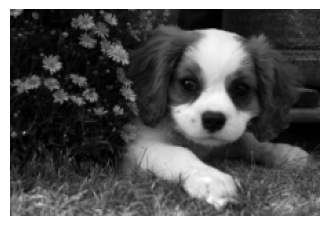

In [ ]:
img_g = rgb2grey_pybk(img2)
show_img(img_g, cmap='gray')

In [ ]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
%pip install -q wurlitzer ninja
%load_ext wurlitzer

def load_cuda(cuda_src, cpp_src, funcs, opt=False, verbose=False):
  return load_inline(cuda_sources=[cuda_src], cpp_sources=[cpp_src], functions=funcs,
                     extra_cuda_cflags=['-O2'] if opt else [], verbose=verbose, name='inline_ext')


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.8/422.8 kB 8.8 MB/s eta 0:00:00


In [ ]:
cuda_begin = r"""
#include <torch/extension.h>
#include <stdio.h>
#include <c10/cuda/CUDAException.h>

#define CHECK_CUDA(x) TORCH_CHECK(x.type().is_cuda(), #x " must be a CUDA tensor")
#define CHECK_CONTIGUOUS(x) TORCH_CHECK(x.is_contiguous(), #x " must be contiguous")
#define CHECK_INPUT(x) CHECK_CUDA(x); CHECK_CONTIGUOUS(x)

inline unsigned int cdiv(unsigned int a, unsigned int b) {
  return (a + b - 1) / b;
}
"""

In [ ]:
cuda_src = cuda_begin + r"""
__global__ void rgb_to_grayscale_kernel(unsigned char* x, unsigned char* out, int n) {
  int i = blockIdx.x * blockDim.x + threadIdx.x;
  if (i < n) {
    out[i] = 0.2989*x[i] + 0.5870*x[i+n] + 0.1140*x[i+2*n];
  }
}

torch::Tensor rgb_to_grayscale(torch::Tensor x) {
  CHECK_INPUT(x);
  int h = x.size(1);
  int w = x.size(2);
  int n = h*w;
  torch::Tensor out = torch::empty({h, w}, x.options());
  int threads = 256;
  int blocks = cdiv(n, threads);
  rgb_to_grayscale_kernel<<<blocks, threads>>>(
    x.data_ptr<unsigned char>(), out.data_ptr<unsigned char>(), n
  );
  C10_CUDA_KERNEL_LAUNCH_CHECK();
  return out;
}
"""

In [ ]:
cpp_src = "torch::Tensor rgb_to_grayscale(torch::Tensor x);"

In [ ]:
module = load_cuda(cuda_src, cpp_src, ['rgb_to_grayscale'], verbose=True)

Using /root/.cache/torch_extensions/py311_cu124 as PyTorch extensions root...
The input conditions for extension module inline_ext have changed. Bumping to version 1 and re-building as inline_ext_v1...
Detected CUDA files, patching ldflags
Emitting ninja build file /root/.cache/torch_extensions/py311_cu124/inline_ext/build.ninja...
/usr/local/lib/python3.11/dist-packages/torch/utils/cpp_extension.py:2059: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
Building extension module inline_ext_v1...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


[1/3] c++ -MMD -MF main.o.d -DTORCH_EXTENSION_NAME=inline_ext_v1 -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1011\" -isystem /usr/local/lib/python3.11/dist-packages/torch/include -isystem /usr/local/lib/python3.11/dist-packages/torch/include/torch/csrc/api/include -isystem /usr/local/lib/python3.11/dist-packages/torch/include/TH -isystem /usr/local/lib/python3.11/dist-packages/torch/include/THC -isystem /usr/local/cuda/include -isystem /usr/include/python3.11 -D_GLIBCXX_USE_CXX11_ABI=0 -fPIC -std=c++17 -c /root/.cache/torch_extensions/py311_cu124/inline_ext/main.cpp -o main.o 
[2/3] /usr/local/cuda/bin/nvcc --generate-dependencies-with-compile --dependency-output cuda.cuda.o.d -DTORCH_EXTENSION_NAME=inline_ext_v1 -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1011\" -isystem /usr/local/lib/python3.11/dist-packages/torch/i

Loading extension module inline_ext_v1...


In [ ]:
dir(module)

['__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'rgb_to_grayscale']

In [ ]:
imgc = img.contiguous().cuda()
img.size()

torch.Size([3, 1066, 1600])

In [ ]:
%%time

img_g = module.rgb_to_grayscale(imgc).cpu()

CPU times: user 1.13 ms, sys: 1.01 ms, total: 2.15 ms
Wall time: 1.42 ms


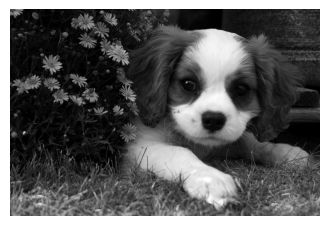

In [ ]:
show_img(img_g, cmap='gray')

In [ ]:
MNIST_URL = "https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/data/mnist.pkl.gz?raw=true"
path_data = Path('data')
path_data.mkdir(exist_ok=True)
path_gz = path_data / 'mnist.pkl.gz'
if not path_gz.is_file():
    urlretrieve(MNIST_URL, path_gz)

In [ ]:
with gzip.open(path_gz, 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)
x_train.shape, x_train.type()


(torch.Size([50000, 784]), 'torch.FloatTensor')

In [ ]:
imgs = x_train.reshape((-1, 28, 28))
imgs.shape

torch.Size([50000, 28, 28])

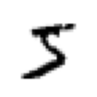

In [ ]:
show_img(imgs[0], cmap='gray_r', figsize=(1, 1))

In [ ]:
torch.manual_seed(1)
weights = torch.randn(784, 10)
weights

tensor([[-1.5256, -0.7502, -0.6540,  ..., -1.6091, -0.7121,  0.3037],
        [-0.7773, -0.2515, -0.2223,  ..., -1.1608,  0.6995,  0.1991],
        [ 0.8657,  0.2444, -0.6629,  ..., -1.4465,  0.0612, -0.6177],
        ...,
        [ 0.5063,  0.4656, -0.2634,  ...,  0.6452,  0.4298, -1.2936],
        [ 0.5171,  1.0315,  0.8120,  ..., -0.1046,  2.2588, -0.2793],
        [-1.4899,  0.3898, -0.5454,  ..., -0.1923, -0.5076,  0.5439]])

In [ ]:
m1 = x_valid[:5]
m2 = weights
m1.shape, m2.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

In [ ]:
ar, ac = m1.shape
br, bc = m2.shape
(ar, ac), (br, bc)

((5, 784), (784, 10))

In [ ]:
t1 = torch.zeros(ar, bc)
t1.shape

torch.Size([5, 10])

In [ ]:
for i in range(ar):
  for j in range(bc):
    for k in range(ac):
      t1[i, j] += m1[i][k]*m2[k][j]

In [ ]:
t1.shape

torch.Size([5, 10])

In [ ]:
import numpy as np
np.set_printoptions(precision=2, linewidth=50)
torch.set_printoptions(precision=2, linewidth=50, sci_mode=False)
t1

tensor([[-21.88,  -1.37, -14.01,  -8.01,  -4.17,
          -6.72,   7.83,  -6.87, -22.94,  -4.23],
        [ 29.09,  12.00,   5.78,  -8.16,  13.18,
         -29.48, -18.56,   4.32, -30.55,  -5.35],
        [  4.44,  -6.43,  -9.60, -12.09,  28.33,
         -17.96,  -9.58, -10.89, -41.35,  27.13],
        [-13.42,  17.80, -14.92, -15.79,   5.40,
          -9.45, -22.06, -25.96, -12.89,   7.28],
        [ -4.89, -12.81,  -4.80, -18.07,  22.35,
         -11.54, -17.84,  -7.57, -17.97,  10.56]])

In [ ]:
def matmul(a, b):
  (ar, ac), (br, bc) = a.shape, b.shape
  c = torch.zeros(ar, bc)
  for i in range(ar):
    for j in range(bc):
      for k in range(ac):
        c[i, j] += a[i][k]*b[k][j]
  return c

In [ ]:
%time _= matmul(m1, m2)

CPU times: user 1.16 s, sys: 4.69 ms, total: 1.17 s
Wall time: 1.25 s


In [ ]:
from types import SimpleNamespace as ns

In [55]:
def blk_kernel2d(f, blocks, threads, *args):
  for i0 in range(blocks.y):
    for i1 in range(blocks.x):
      for j0 in range(threads.y):
        for j1 in range(threads.y):
          f(ns(x=i0, y=i1), ns(x=j0, y=j1), threads, *args)

In [56]:
def matmul_blk(blockidx, threadidx, blockdim, m, n, out, h, w, k):
  r = blockidx.y + blockdim.y + threadidx.y
  c = blockidx.x = blockdim.x + threadidx.x

  if (r>=h or c>=w): return
  o = 0.
  for i in range(k): o += m[r*k+i] + n[i*w+c]
  out[r*w+c] = o

In [57]:
def matmul_2d(m, n):
  h, k = m.shape
  k2, w = n.shape
  assert k == k2, "Size mismatch!"
  output = torch.zeros(h, w, dtype=m.dtype)
  tpb = ns(x=16, y=16) # threads per block
  blocks = ns(x=math.ceil(w/tpb.x), y=math.ceil(h/tpb.y))
  blk_kernel2d(matmul_blk, blocks, tpb, m, n, output, h, w, k)
  return output

In [58]:
def matmul(a, b):
  ar, ac = a.shape
  br, bc = b.shape
  c = torch.zeros(ar, bc)
  for i in range(ar): c[i] = (a[i,:,None]*b).sum(dim=0)
  return c

In [59]:
m1 = x_train
tr = matmul(m1, m2)
tr.shape

torch.Size([50000, 10])

In [60]:
%time _=matmul(m1, m2)

CPU times: user 1.42 s, sys: 4.55 ms, total: 1.43 s
Wall time: 1.54 s


In [63]:
ar,ac = m1.shape
br,bc = m2.shape
ar*bc*ac

392000000

In [67]:
cuda_src = cuda_begin + r"""
__global__ void matmul_k(float* m, float* n, float* out, int h, int w, int k) {
  int r = blockIdx.y*blockDim.y + threadIdx.y;
  int c = blockIdx.x*blockDim.x + threadIdx.x;

  if (r>=h || c>=w) return;
  float o = 0;
  for (int i=0; i<k; i++) o += m[r*k+i]*n[i*w+c];
  out[r*w+c] = o;
}

torch::Tensor matmul(torch::Tensor m, torch::Tensor n) {
  CHECK_INPUT(m);
  CHECK_INPUT(n);
  int h = m.size(0);
  int w = n.size(1);
  int k = m.size(1);
  TORCH_CHECK(n.size(0) == m.size(1), "Size mismatch!");
  torch::Tensor out = torch::zeros({h, w}, m.options());

  dim3 tpb(16, 16);
  dim3 blocks(cdiv(w, tpb.x), cdiv(h, tpb.y));
  matmul_k<<<blocks, tpb>>>(
    m.data_ptr<float>(), n.data_ptr<float>(), out.data_ptr<float>(), h, w, k);
  C10_CUDA_KERNEL_LAUNCH_CHECK();
  return out;
}
"""

cpp_src = "torch::Tensor matmul(torch::Tensor m, torch::Tensor n);"
module = load_cuda(cuda_src, cpp_src, ['matmul'], verbose=True)

Using /root/.cache/torch_extensions/py311_cu124 as PyTorch extensions root...
The input conditions for extension module inline_ext have changed. Bumping to version 5 and re-building as inline_ext_v5...
Detected CUDA files, patching ldflags
Emitting ninja build file /root/.cache/torch_extensions/py311_cu124/inline_ext/build.ninja...
/usr/local/lib/python3.11/dist-packages/torch/utils/cpp_extension.py:2059: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
Building extension module inline_ext_v5...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


[1/3] c++ -MMD -MF main.o.d -DTORCH_EXTENSION_NAME=inline_ext_v5 -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1011\" -isystem /usr/local/lib/python3.11/dist-packages/torch/include -isystem /usr/local/lib/python3.11/dist-packages/torch/include/torch/csrc/api/include -isystem /usr/local/lib/python3.11/dist-packages/torch/include/TH -isystem /usr/local/lib/python3.11/dist-packages/torch/include/THC -isystem /usr/local/cuda/include -isystem /usr/include/python3.11 -D_GLIBCXX_USE_CXX11_ABI=0 -fPIC -std=c++17 -c /root/.cache/torch_extensions/py311_cu124/inline_ext/main.cpp -o main.o 
[2/3] /usr/local/cuda/bin/nvcc --generate-dependencies-with-compile --dependency-output cuda.cuda.o.d -DTORCH_EXTENSION_NAME=inline_ext_v5 -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1011\" -isystem /usr/local/lib/python3.11/dist-packages/torch/i

Loading extension module inline_ext_v5...


In [68]:
m1c, m2c = m1.contiguous().cuda(), m2.contiguous().cuda()

In [71]:
%%time
res = module.matmul(m1c, m2c).cpu()

CPU times: user 6.44 ms, sys: 0 ns, total: 6.44 ms
Wall time: 6.12 ms


In [72]:
torch.isclose(tr, res, atol=1e-5).all()

tensor(True)